# R-CNN Implementation

In [2]:
import selectivesearch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
from torchvision.datasets import VOCDetection
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models


## Dataset preparing

Fine-tuning : VOC 2012 train set

SVM         : VOC 2012 trainval set

Test        : VOC 2007 trainval set

In [2]:
train_data_finetuning = VOCDetection(root='data/finetuning',
                                     year='2012',
                                     image_set='train',
                                     download=False)

train_data_SVM = VOCDetection(root='data/SVM',
                              year='2012',
                              image_set='trainval',
                              download=False)

test_data = VOCDetection(root='data/test',
                         year='2007',
                         image_set='trainval',
                         download=False)

## Functions

In [3]:
def get_iou(bb1, bb2):
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area + 1e-20)
    
    return iou

In [4]:
def convert_to_topbottom(bboxes):
    out = []
    for bbox in bboxes:
        xmin = bbox[0]
        ymin = bbox[1]
        xmax = xmin + bbox[2]
        ymax = ymin + bbox[3]
        out.append((xmin, ymin, xmax, ymax))
    
    return out

In [2]:
import cv2
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.switchToSelectiveSearchFast()


In [ ]:
def finetuning_labeling(root, dataset, train_step, trg_classes, threshold, num_samples):
    positive_list = []
    negative_list = []
    cnt = 0

    for (src, trg) in dataset:
        flag = 0
        filename = trg['annotation']['filename']
        
        # 훈련에 사용할 class의 object가 있는 경우만 SS를 이용할 것임.
        for object in trg['annotation']['object']:
            for trg_class in trg_classes:
                if object['name'] == trg_class:
                    flag = 1
                    
        # 훈련에 사용할 class의 object가 있으므로 SS를 통해 lableing을 진행.
        if flag == 1:
            if cnt < num_samples:
                cnt += 1
                src = np.array(src)
            
                _, regions = selectivesearch.selective_search(src, scale=500, min_size=10)
                
                rois = [box['rect'] for box in regions]
                rois = convert_to_topbottom(rois)
                
                for object in trg['annotation']['object']:
                    for trg_class in trg_classes:
                        if object['name'] == trg_class:
                            for roi in rois:
                                temp = {}
                                gt_roi_coord = tuple(map(int, tuple(object['bndbox'].values())))
                                iou = get_iou(roi, gt_roi_coord)
                                if iou >= threshold:
                                    temp['filename'] = filename
                                    temp['name'] = trg_class
                                    temp['xmin'], temp['ymin'], temp['xmax'], temp['ymax'] = roi
                                    positive_list.append(temp) 
                                else:
                                    temp['filename'] = filename
                                    temp['name'] = 'background'
                                    temp['xmin'], temp['ymin'], temp['xmax'], temp['ymax'] = roi
                                    negative_list.append(temp)
            else:
                break
        else:
            continue

    pos_csv = pd.DataFrame.from_dict(positive_list)
    neg_csv = pd.DataFrame.from_dict(negative_list)

    pos_csv.to_csv(os.path.join(root, train_step + '_positive.csv'), mode='w')
    neg_csv.to_csv(os.path.join(root, train_step + '_negative.csv'), mode='w')

    return pos_csv, neg_csv

In [67]:
def labeling(root, dataset, train_step, trg_classes, threshold, num_samples):
    positive_list = []
    negative_list = []
    cnt = 0

    for (src, trg) in dataset:
        flag = 0
        filename = trg['annotation']['filename']
        
        # 훈련에 사용할 class의 object가 있는 경우만 SS를 이용할 것임.
        for object in trg['annotation']['object']:
            for trg_class in trg_classes:
                if object['name'] == trg_class:
                    flag = 1
                    
        # 훈련에 사용할 class의 object가 있으므로 SS를 통해 lableing을 진행.
        if flag == 1:
            if cnt < num_samples:
                cnt += 1
                src = np.array(src)
            
                _, regions = selectivesearch.selective_search(src, scale=500, min_size=10)
                
                rois = [box['rect'] for box in regions]
                rois = convert_to_topbottom(rois)
                
                for object in trg['annotation']['object']:
                    for trg_class in trg_classes:
                        if object['name'] == trg_class:
                            for roi in rois:
                                temp = {}
                                gt_roi_coord = tuple(map(int, tuple(object['bndbox'].values())))
                                iou = get_iou(roi, gt_roi_coord)
                                if iou >= threshold:
                                    temp['filename'] = filename
                                    temp['name'] = trg_class
                                    temp['xmin'], temp['ymin'], temp['xmax'], temp['ymax'] = roi
                                    positive_list.append(temp) 
                                else:
                                    temp['filename'] = filename
                                    temp['name'] = 'background'
                                    temp['xmin'], temp['ymin'], temp['xmax'], temp['ymax'] = roi
                                    negative_list.append(temp)
            else:
                break
        else:
            continue

    pos_csv = pd.DataFrame.from_dict(positive_list)
    neg_csv = pd.DataFrame.from_dict(negative_list)

    pos_csv.to_csv(os.path.join(root, train_step + '_positive.csv'), mode='w')
    neg_csv.to_csv(os.path.join(root, train_step + '_negative.csv'), mode='w')

    return pos_csv, neg_csv

## Region Proposals

In [21]:
from PIL import Image

class FineTuningDataset(Dataset):
    def __init__(self, root, csv_file, classes, transform=None):
        self.csv_file = pd.read_csv(os.path.join(root, csv_file))
        self.root = root
        self.transform = transform
        self.classes = classes
        
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        filename = self.csv_file.iloc[idx, 1]
        bndbox = tuple(self.csv_file.iloc[idx, 3:7])
        img = Image.open(os.path.join(self.root, filename)).crop(bndbox).convert('RGB').resize((224, 224), Image.NEAREST)
        trg = torch.zeros(len(self.classes))
        trg[self.classes.index(self.csv_file.iloc[idx, 2])] = 1
        
        if self.transform:
            src = self.transform(img)
        
        return src, trg  

In [ ]:
classes = [
    'background',
    # 'aeroplane',
    # 'bicycle',
    # 'bird',
    # 'boat',
    # 'bottle',
    # 'bus',
    # 'car',
    # 'cat',
    # 'chair',
    # 'cow',
    # 'diningtable',
    # 'dog',
    # 'horse',
    # 'motorbike',
    'person',
    # 'pottedplant',
    # 'sheep',
    # 'sofa',
    # 'train',
    # 'tvmonitor'
]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

root = 'data/finetuning/VOCdevkit/VOC2012/JPEGImages'

ft_pos_csv, ft_neg_csv = finetuning_labeling(root, train_data_finetuning, 'finetuning', classes[1:], threshold=0.5, num_samples=10)

In [ ]:
num_epochs = 2
batch_size = 64
positive_size = batch_size // 4
negative_size = batch_size // 4 * 3

model = models.mobilenet_v2(pretrained=True).to(device)

model.classifier[1] = nn.Linear(model.last_channel, len(classes))

ft_positive_dataset = FineTuningDataset(root, 'finetuning_positive.csv', classes, transforms.ToTensor())
ft_negative_dataset = FineTuningDataset(root, 'finetuning_negative.csv', classes, transforms.ToTensor())

ft_positive_dataloader = DataLoader(ft_positive_dataset, positive_size, shuffle=True, num_workers=2, drop_last=True)
ft_negative_dataloader = DataLoader(ft_negative_dataset, negative_size, shuffle=True, num_workers=2, drop_last=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=4e-3)

losses = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    
    for batch_idx, ((pos_src, pos_trg), (neg_src, neg_trg)) in enumerate(zip(ft_positive_dataloader, ft_negative_dataloader)):
        src = torch.cat((pos_src, neg_src)).to(device)
        trg = torch.cat((pos_trg, neg_trg)).to(device)

        optimizer.zero_grad()

        output = model(src)
        _, preds = torch.max(output.data, 1)
        loss = criterion(output, trg)

        losses.append(loss.item())
        print(f"Batch: {batch_idx}, Loss:{loss.item()}")
        loss.backward()
        optimizer.step()

In [ ]:
torch.save(model.state_dict(), 'ft_model_state_dict')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.plot(losses)
plt.show()

In [82]:
def svm_labeling(root, dataset, train_step, trg_classes, threshold, num_samples):
    # Finetuning labeling과 다르다.
    # Positive sample은 GT_bbox, Negative sample은 RoI와 GT_bbox의 IoU가 threshold보다 낮은 RoI
    positive_list = []
    negative_list = []
    temp = {}
    cnt = 0

    for (src, trg) in dataset:
        flag = 0
        filename = trg['annotation']['filename']
        
        # 훈련에 사용할 class의 object가 있는 경우만 SS를 이용할 것임.
        for object in trg['annotation']['object']:
            for trg_class in trg_classes:
                if object['name'] == trg_class:          
                    flag = 1
                    
        # 훈련에 사용할 class의 object가 있으므로 SS를 통해 lableing을 진행.
        if flag == 1:
            if cnt < num_samples:
                cnt += 1
                src = np.array(src)
            
                _, regions = selectivesearch.selective_search(src, scale=500, min_size=100)
                
                rois = [box['rect'] for box in regions]
                rois = convert_to_topbottom(rois)
                
                for object in trg['annotation']['object']:
                    for trg_class in trg_classes:
                        if object['name'] == trg_class:
                            gt_roi_coord = tuple(map(int, tuple(object['bndbox'].values())))
                            temp['filename'] = filename
                            temp['name'] = object['name']
                            temp['xmin'], temp['ymin'], temp['xmax'], temp['ymax'] = gt_roi_coord
                            positive_list.append(temp) 
                            for roi in rois:
                                temp = {}
                                iou = get_iou(roi, gt_roi_coord)
                                if iou >= threshold:
                                    pass
                                else:
                                    temp['filename'] = filename
                                    temp['name'] = 'background'
                                    temp['xmin'], temp['ymin'], temp['xmax'], temp['ymax'] = roi
                                    negative_list.append(temp)
            else:
                break
        else:
            continue

    pos_csv = pd.DataFrame.from_dict(positive_list)
    neg_csv = pd.DataFrame.from_dict(negative_list)

    pos_csv.to_csv(os.path.join(root, train_step + '_positive.csv'), mode='w')
    neg_csv.to_csv(os.path.join(root, train_step + '_negative.csv'), mode='w')

    return pos_csv, neg_csv

In [93]:
from PIL import Image

class SVMDataset(Dataset):
    def __init__(self, root, csv_file, classes, transform=None):
        self.csv_file = pd.read_csv(os.path.join(root, csv_file))
        self.root = root
        self.transform = transform
        self.classes = classes
        
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        filename = self.csv_file.iloc[idx, 1]
        bndbox = tuple(self.csv_file.iloc[idx,3:7])
        img = Image.open(os.path.join(self.root, filename)).crop(bndbox).convert('RGB').resize((224, 224), Image.NEAREST)
        trg = torch.zeros(len(self.classes))
        trg[self.classes.index(self.csv_file.iloc[idx, 2])] = 1
        
        if self.transform:
            src = self.transform(img)
        
        return src, trg

In [89]:
root = 'data/SVM/VOCdevkit/VOC2012/JPEGImages'

svm_pos_csv, svm_neg_csv = svm_labeling(root, train_data_SVM, 'svm', classes[1:], threshold=0.5, num_samples=100)

In [95]:
num_epochs = 2
batch_size = 64
positive_size = batch_size // 4
negative_size = batch_size // 4 * 3

svm_positive_dataset = SVMDataset(root, 'svm_positive.csv', classes, transforms.ToTensor())
svm_negative_dataset = SVMDataset(root, 'svm_negative.csv', classes, transforms.ToTensor())

svm_positive_dataloader = DataLoader(svm_positive_dataset, positive_size, shuffle=True, num_workers=2, drop_last=True)
svm_negative_dataloader = DataLoader(svm_negative_dataset, negative_size, shuffle=True, num_workers=2, drop_last=True)

optimizer = torch.optim.SGD(model.parameters(), lr=4e-3)

svm_losses = []

In [ ]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)
    
    for batch_idx, ((pos_src, pos_trg), (neg_src, neg_trg)) in enumerate(zip(svm_positive_dataloader, svm_negative_dataloader)):
        src = torch.cat((pos_src, neg_src)).to(device)
        trg = torch.cat((pos_trg, neg_trg)).to(device)

        optimizer.zero_grad()

        output = model(src)
        loss = torch.mean(torch.clamp(1 - output * trg, min=0))
        svm_losses.append(loss.item())
        print(f"Batch: {batch_idx}, Loss:{loss.item()}")
        loss.backward()
        optimizer.step()

In [ ]:
torch.save(model.state_dict(), 'svm_model_state_dict')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.plot(svm_losses)
plt.show()

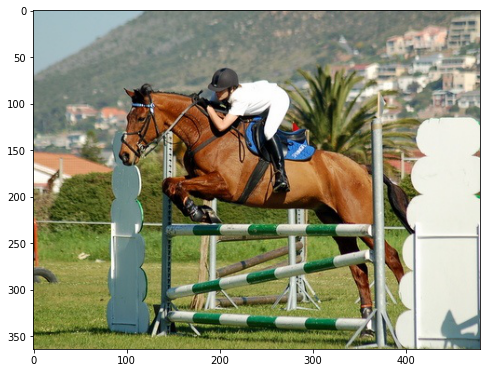

In [117]:
import cv2

src, trg = test_data[5]

src = np.array(src)
_, regions = selectivesearch.selective_search(src, scale=500, min_size=100)
                
rois = [box['rect'] for box in regions]
rois = convert_to_topbottom(rois)

plt.figure(figsize=(8, 8))
plt.imshow(src)
plt.show()


In [3]:
model = torch.load('svm_model').to(device)
model.eval()

NameError: name 'device' is not defined

In [130]:
from tqdm import tqdm

green_rgb = (125, 255, 51)
img_rgb_copy = src.copy()


for rect in tqdm(rois):
    left = rect[0]
    top = rect[1]
    right = left + rect[2]
    bottom = top + rect[3]
    for inp in input:
        if inp.shape[0] != 0 and inp.shape[1] != 0:
            output = model(torch.Tensor(inp).unsqueeze(0).permute(0,3,1,2)).to(device)
            result = classes[output.argmax().item()]
            if result == 'person':
              img_rgb_copy = cv2.rectangle(img_rgb_copy, (left, top), (right, bottom), color=green_rgb, thickness=2)


plt.figure(figsize=(8, 8))
plt.imshow(img_rgb_copy)
plt.show()

  1%|          | 2/225 [00:05<09:39,  2.60s/it]


KeyboardInterrupt: 